# Human Activity

https://learnopencv.com/introduction-to-video-classification-and-human-activity-recognition/

In [2]:
import os
import sys
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
from pathlib import Path
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split

Asignar constantes para obtener resultados consistentes

In [3]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Visualizar muestras de datos

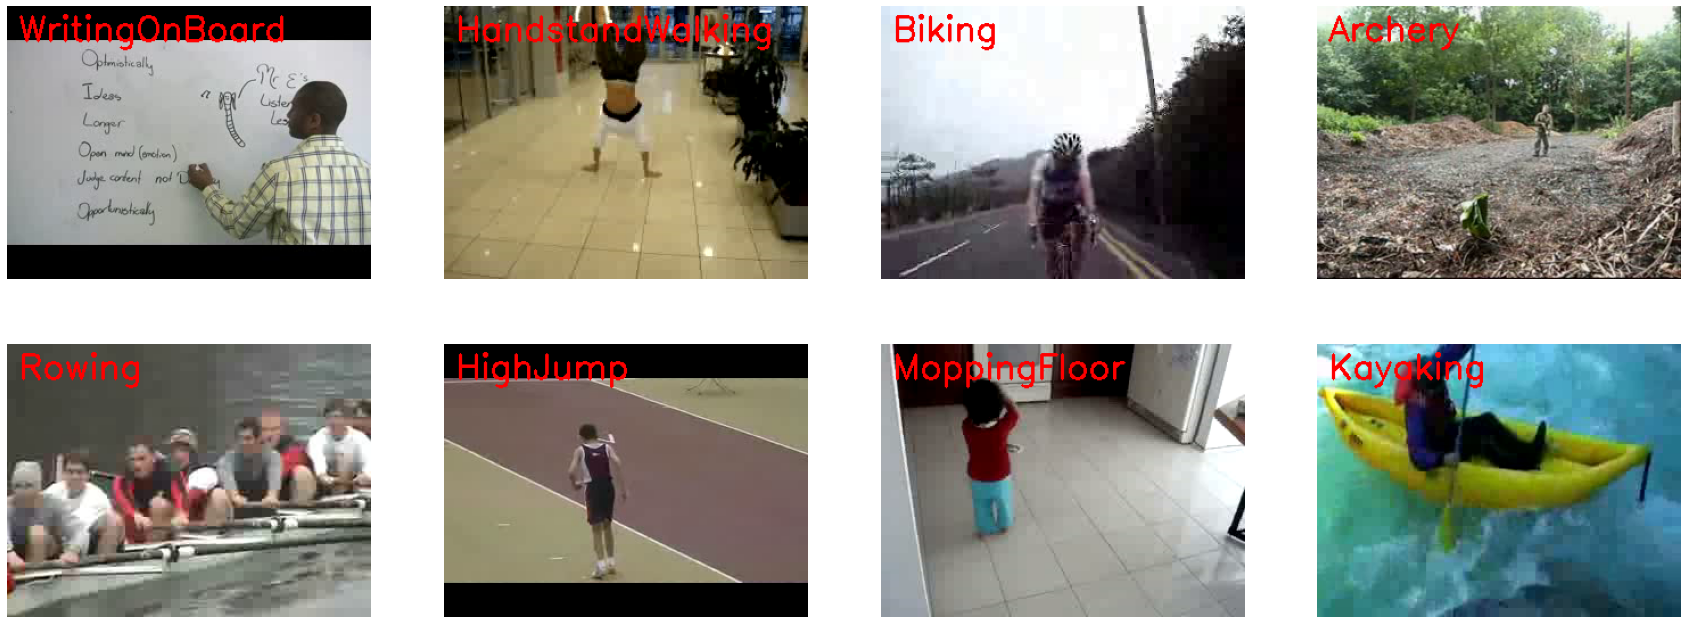

In [4]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir('../Dataset/UCF101')

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 8)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'../Dataset/UCF101/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'../Dataset/UCF101/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

## Leer y preprocesar el dataset
Nota: Las variables constantes image_height, image_weight y max_images_per_class deberian ser aumentadas para obtener unos mejores resultados pero computacionalmente sera más dificil.

In [5]:
image_height, image_width = 64, 64
max_images_per_class = 8000

dataset_directory = "../Dataset/UCF101"
classes_list = ["HighJump", "PoleVault", "JavelinThrow","ThrowDiscus","LongJump","Biking"]

model_output_size = len(classes_list)

### Extraer, reescalar y normalizar los frames

In [6]:
from src.VideoProcessing import ActivtyFrames

In [7]:
acframes = ActivtyFrames()
features, labels = acframes.create_dataset(classes_list,dataset_directory,max_images_per_class,image_height,image_width)

Extracting Data of Class: HighJump
Extracting Data of Class: PoleVault
Extracting Data of Class: JavelinThrow
Extracting Data of Class: ThrowDiscus
Extracting Data of Class: LongJump
Extracting Data of Class: Biking


In [8]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## Dividiendo datos en test y training

In [9]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

## Creando el modelo

In [10]:
model = acframes.create_model(model_output_size,image_height,image_width)
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

## Compilando y entrenando el modelo

In [12]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
7680/7680 [==============================] - 51s 6ms/step - loss: 1.4992 - accuracy: 0.4145 - val_loss: 1.6677 - val_accuracy: 0.5757
Epoch 2/50
7680/7680 [==============================] - 41s 5ms/step - loss: 0.8717 - accuracy: 0.6943 - val_loss: 0.8777 - val_accuracy: 0.7632
Epoch 3/50
7680/7680 [==============================] - 43s 6ms/step - loss: 0.6577 - accuracy: 0.7769 - val_loss: 1.8171 - val_accuracy: 0.6637
Epoch 4/50
7680/7680 [==============================] - 41s 5ms/step - loss: 0.5578 - accuracy: 0.8094 - val_loss: 0.3519 - val_accuracy: 0.8837
Epoch 5/50
7680/7680 [==============================] - 42s 5ms/step - loss: 0.4835 - accuracy: 0.8369 - val_loss: 0.4879 - val_accuracy: 0.8695
Epoch 6/50
7680/7680 [==============================] - 42s 5ms/step - loss: 0.4400 - accuracy: 0.8549 - val_loss: 0.4075 - val_accuracy: 0.8874
Epoch 7/50
7680/7680 [==============================] - 41s 5ms/step - loss: 0.4049 - accuracy: 0.8684 - val_loss: 0.1786 - val_ac

### Evaluando el modelo entrenado

In [13]:
model_evaluation_history = model.evaluate(features_test, labels_test)
print(model_evaluation_history)

300/300 [==============================] - 2s 5ms/step - loss: 0.1536 - accuracy: 0.9673
[0.15358702838420868, 0.9672916531562805]


## Hacer predicciones con el modelo entrenado
### Descargar el video

* Pole Vault: https://www.youtube.com/watch?v=UfGIZX7enN8
* Javelin Throw: https://www.youtube.com/watch?v=_UwUVbHIgAs
* High Jump: https://www.youtube.com/watch?v=QTkVfboHKsg
* Running: https://www.youtube.com/watch?v=1g8mqfNvSHA
* Basketball: https://www.youtube.com/watch?v=4HFAOvTnGB4

In [27]:
# Creating The Output directories if it does not exist
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok = True)

# Downloading a YouTube Video
video_title = acframes.download_youtube_videos('https://www.youtube.com/watch?v=1g8mqfNvSHA', output_directory)

# Getting the YouTube Video's path you just downloaded
input_video_file_path = f'{output_directory}/{video_title}.mp4'

### Ver los resultados

In [14]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

        # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
        predicted_labels_probabilities_deque = deque(maxlen = window_size)

        # Reading the Video File using the VideoCapture Object
        video_reader = cv2.VideoCapture(video_file_path)

        # Getting the width and height of the video 
        original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
        original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Writing the Overlayed Video Files Using the VideoWriter Object
        video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

        while True: 

            # Reading The Frame
            status, frame = video_reader.read() 

            if not status:
                break

            # Resize the Frame to fixed Dimensions
            resized_frame = cv2.resize(frame, (image_height, image_width))
            
            # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
            normalized_frame = resized_frame / 255

            # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
            predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

            # Appending predicted label probabilities to the deque object
            predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

            # Assuring that the Deque is completely filled before starting the averaging process
            if len(predicted_labels_probabilities_deque) == window_size:

                # Converting Predicted Labels Probabilities Deque into Numpy array
                predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

                # Calculating Average of Predicted Labels Probabilities Column Wise 
                predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

                # Converting the predicted probabilities into labels by returning the index of the maximum value.
                predicted_label = np.argmax(predicted_labels_probabilities_averaged)

                # Accessing The Class Name using predicted label.
                predicted_class_name = classes_list[predicted_label]
            
                # Overlaying Class Name Text Ontop of the Frame
                cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            # Writing The Frame
            video_writer.write(frame)


            # cv2.imshow('Predicted Frames', frame)

            # key_pressed = cv2.waitKey(10)

            # if key_pressed == ord('q'):
            #     break

        # cv2.destroyAllWindows()

        
        # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
        video_reader.release()
        video_writer.release()

In [28]:
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 1

# Constructing The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
# VideoFileClip(output_video_file_path).ipython_display(width = 700)